In [12]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import matplotlib.pyplot as plt




In [13]:
class FER2013LabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Emotion classes (based on the FER2013 dataset)
        self.classes = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
        
        # Prepare the image paths and corresponding labels
        self.image_paths = []
        self.labels = []
        
        # Loop through each emotion subfolder and assign labels
        for idx, emotion in enumerate(self.classes):
            emotion_dir = os.path.join(root_dir, emotion)
            for filename in os.listdir(emotion_dir):
                if filename.endswith('.jpg'):  # or '.png' depending on file type
                    self.image_paths.append(os.path.join(emotion_dir, filename))
                    self.labels.append(idx)  # Label based on folder (Anger=0, Disgust=1, etc.)

        self.dataset = pd.DataFrame({
                'image_paths': self.image_paths,
                'labels': self.labels
            })


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        label = self.labels[idx]
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
        
        return image, label
    

# Usage example
train_data = FER2013LabelDataset(root_dir=r'archive/train/', transform=transforms.ToTensor())
test_data = FER2013LabelDataset(root_dir=r'archive/test/', transform=transforms.ToTensor())





In [14]:
tensor = train_data[1][0]
print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([1, 48, 48])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


visualizing label assigment.

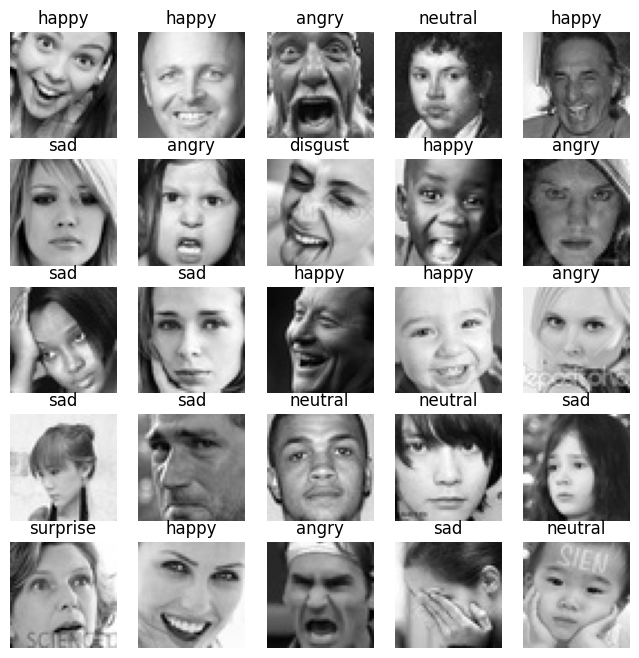

In [23]:

figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(train_data.classes[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [24]:

import torch.nn as nn
import torch.nn.functional as F

class EmotionRecognitionCNN(nn.Module):
    def __init__(self):
        super(EmotionRecognitionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 12 * 12, 512)  # 12x12 after pooling (48/2 -> 24 -> 12)
        self.fc2 = nn.Linear(512, 7)  # Output 7 classes (Anger, Disgust, etc.)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 12 * 12)  # Flatten for fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [25]:
model = EmotionRecognitionCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [35]:
from torch.utils.data import DataLoader
from tqdm import tqdm  # Corrected import

# Assuming you already have the train_data and test_data
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)  # Corrected to use test_data

EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Create a tqdm progress bar
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", unit="batch")

    for images, labels in progress_bar:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy (if necessary)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        # Update the progress bar description
        progress_bar.set_postfix(loss=running_loss/len(train_loader), 
                                 accuracy=correct_predictions/total_predictions)

    # Print Epoch summary
    avg_loss = running_loss / len(train_loader)
    avg_accuracy = correct_predictions / total_predictions
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}")


Epoch 1/10:   0%|          | 0/449 [00:00<?, ?batch/s]

Epoch 1/10: 100%|██████████| 449/449 [03:08<00:00,  2.39batch/s, accuracy=0.425, loss=1.48] 


Epoch 1/10 - Loss: 1.4768, Accuracy: 0.4255


Epoch 2/10: 100%|██████████| 449/449 [01:07<00:00,  6.66batch/s, accuracy=0.487, loss=1.33] 


Epoch 2/10 - Loss: 1.3341, Accuracy: 0.4867


Epoch 3/10: 100%|██████████| 449/449 [01:09<00:00,  6.47batch/s, accuracy=0.537, loss=1.22] 


Epoch 3/10 - Loss: 1.2177, Accuracy: 0.5374


Epoch 4/10: 100%|██████████| 449/449 [01:07<00:00,  6.68batch/s, accuracy=0.585, loss=1.1]  


Epoch 4/10 - Loss: 1.1001, Accuracy: 0.5853


Epoch 5/10: 100%|██████████| 449/449 [01:06<00:00,  6.71batch/s, accuracy=0.639, loss=0.971]


Epoch 5/10 - Loss: 0.9713, Accuracy: 0.6394


Epoch 6/10: 100%|██████████| 449/449 [01:06<00:00,  6.71batch/s, accuracy=0.704, loss=0.82] 


Epoch 6/10 - Loss: 0.8200, Accuracy: 0.7037


Epoch 7/10: 100%|██████████| 449/449 [01:07<00:00,  6.61batch/s, accuracy=0.769, loss=0.656]


Epoch 7/10 - Loss: 0.6561, Accuracy: 0.7687


Epoch 8/10: 100%|██████████| 449/449 [01:07<00:00,  6.70batch/s, accuracy=0.834, loss=0.491]


Epoch 8/10 - Loss: 0.4906, Accuracy: 0.8339


Epoch 9/10: 100%|██████████| 449/449 [01:06<00:00,  6.71batch/s, accuracy=0.887, loss=0.346] 


Epoch 9/10 - Loss: 0.3464, Accuracy: 0.8871


Epoch 10/10: 100%|██████████| 449/449 [01:08<00:00,  6.59batch/s, accuracy=0.932, loss=0.225] 

Epoch 10/10 - Loss: 0.2253, Accuracy: 0.9321


In [36]:
# Evaluate on test data
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
correct_predictions = 0
total_predictions = 0

In [37]:
with torch.no_grad():
    for images, labels in test_loader:
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

# Print test summary
avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct_predictions / total_predictions
print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 2.0762, Test Accuracy: 0.5294


In [38]:
torch.save(model.state_dict(), "emotion_model.pth")
print("Model saved as 'emotion_model.pth'")

Model saved as 'emotion_model.pth'
